In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set the base directory for your datasets
base_dir = '/content/drive/MyDrive/Weather_Classification'

folders = os.listdir(base_dir)
print(folders)

['train', 'test']


In [4]:
import matplotlib.pyplot as plt
import random
import cv2
import tqdm as tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
root_dir = "/kaggle/input/multiclass-weather-dataset/dataset/"
os.listdir(root_dir)

['cloudy', 'sunrise', 'alien_test', 'shine', 'test.csv', 'foggy', 'rainy']

The code defines file paths to different weather condition categories (foggy, sunrise, shine, rainy, cloudy) and a test category (alien_test) stored in a directory structure for a weather classification project.

In [6]:
foggy = "/content/drive/MyDrive/Weather_Classification/train/foggy"
sunrise = "/content/drive/MyDrive/Weather_Classification/train/sunrise"
shine = "/content/drive/MyDrive/Weather_Classification/train/shine"
rainy = "/content/drive/MyDrive/Weather_Classification/train/rainy"
cloudy = "/content/drive/MyDrive/Weather_Classification/train/cloudy"
test = "/content/drive/MyDrive/Weather_Classification/test/alien_test"

In [7]:
print("Number of Images in Each Directory:")
print(f"Foggy: {len(os.listdir(foggy))}")
print(f"Sunrise: {len(os.listdir(sunrise))}")
print(f"Shine: {len(os.listdir(shine))}")
print(f"Rainy: {len(os.listdir(rainy))}")
print(f"Cloudy: {len(os.listdir(cloudy))}")

Number of Images in Each Directory:
Foggy: 300
Sunrise: 350
Shine: 250
Rainy: 309
Cloudy: 300


Data Prprocessing

In [8]:
x = []
y = []
dataset =[]
def create_dataset(directory,dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)
        try:
            img = cv2.imread(full_path)
            img = cv2.resize(img,(150,150))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

It is a function to create_dataset that iterates over images in a specified directory, resizes each image to 150x150 pixels, appends them to a list x, and associates each image with a label dir_name in a list y, using tqdm for progress tracking.

In [9]:
x,y= create_dataset(foggy,"foggy")
x,y= create_dataset(sunrise,"sunrise")
x,y= create_dataset(shine,"shine")
x,y= create_dataset(rainy,"rainy")
x,y= create_dataset(cloudy,"cloudy")

100%|██████████| 300/300 [00:06<00:00, 48.77it/s]


loads and processes images from directories representing different weather conditions (foggy, sunrise, shine, rainy, cloudy), resizing them and assigning appropriate labels, then aggregates them into datasets x (images) and y (labels).

In [10]:
x =  np.array(x)
y = np.array(y)
x.shape,y.shape

((1507, 150, 150, 3), (1507,))

The code converts the lists x (images) and y (labels) into NumPy arrays and retrieves their shapes, indicating the number of images and labels along with the dimensions of the images.

Plotting images

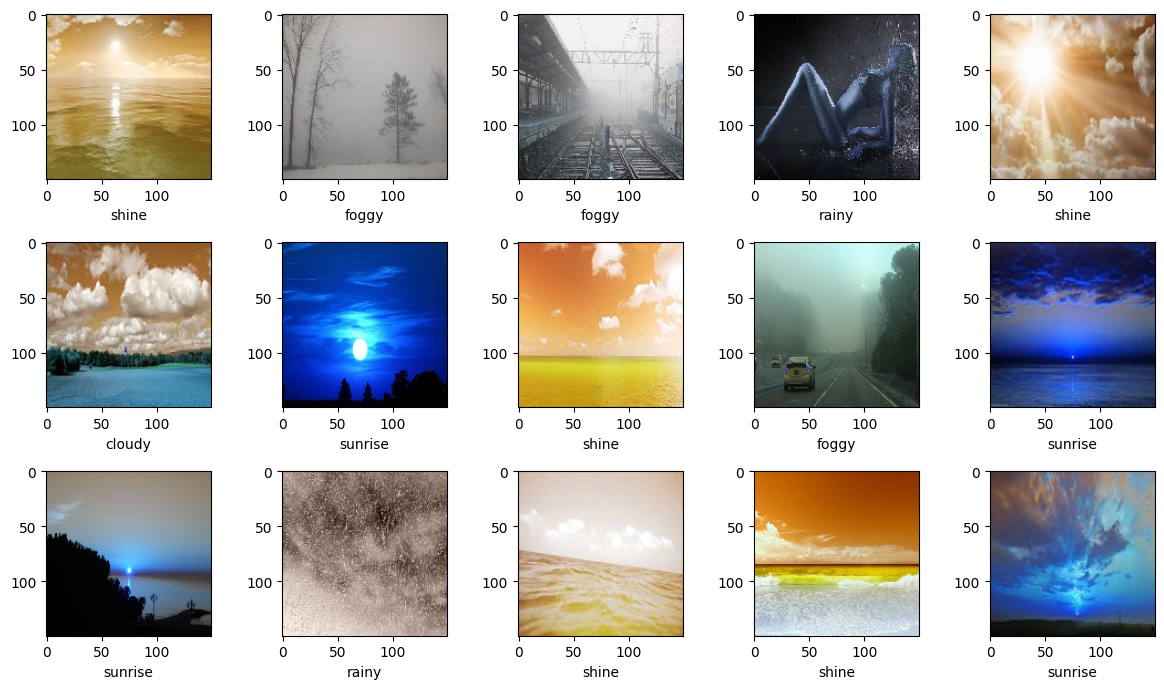

In [11]:
fig = plt.figure(figsize=(12,7))
for i in range(15):
    sample =  random.choice(range(len(x)))
    image = x[sample]
    category = y[sample]
    plt.subplot(3,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image)
    plt.xlabel(category)

plt.tight_layout()
plt.show()

Label Encoding

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

initializes a LabelEncoder from scikit-learn, and then transforms the array y containing categorical labels into a numerical format, where each unique label is assigned a unique integer.

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [14]:
img_size =150

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0


x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)

In [15]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

In [16]:
y_train_lb.shape,y_test_lb.shape

((1205, 5), (302, 5))

Model - VGG-19

In [17]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights = "imagenet",include_top=False,input_shape=(img_size,img_size,3))

80134624/80134624 [==============================] - 1s 0us/step


In [18]:
for layer in vgg.layers:
    layer.trainable = False

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model =Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(5,activation="softmax"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 5)                 40965     
                                                                 
Total params: 20065349 (76.54 MB)
Trainable params: 40965 (160.02 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [21]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [22]:
unique,counts = np.unique(y_train_lb,return_counts=True)
print(unique,counts)

[0 1] [4820 1205]


In [ ]:
batch_size=32
history =  model.fit(x_train,y_train_lb,epochs=15,validation_data=(x_test,y_test_lb),
                     batch_size=32 ,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
 1/38 [..............................] - ETA: 4:56 - loss: 1.9208 - accuracy: 0.2812

I0000 00:00:1708236813.092694      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 [==============================] - ETA: 0s - loss: 0.9762 - accuracy: 0.6302
Epoch 1: val_accuracy improved from -inf to 0.84333, saving model to vgg19.h5
38/38 [==============================] - 17s 242ms/step - loss: 0.9762 - accuracy: 0.6302 - val_loss: 0.4970 - val_accuracy: 0.8433
Epoch 2/15


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/38 [============================>.] - ETA: 0s - loss: 0.4722 - accuracy: 0.8505
Epoch 2: val_accuracy improved from 0.84333 to 0.89333, saving model to vgg19.h5
38/38 [==============================] - 4s 101ms/step - loss: 0.4686 - accuracy: 0.8523 - val_loss: 0.3477 - val_accuracy: 0.8933
Epoch 3/15
37/38 [============================>.] - ETA: 0s - loss: 0.3476 - accuracy: 0.9020
Epoch 3: val_accuracy improved from 0.89333 to 0.93000, saving model to vgg19.h5
38/38 [==============================] - 4s 102ms/step - loss: 0.3456 - accuracy: 0.9032 - val_loss: 0.2807 - val_accuracy: 0.9300
Epoch 4/15
37/38 [============================>.] - ETA: 0s - loss: 0.2655 - accuracy: 0.9383
Epoch 4: val_accuracy improved from 0.93000 to 0.94000, saving model to vgg19.h5
38/38 [==============================] - 4s 102ms/step - loss: 0.2654 - accuracy: 0.9374 - val_loss: 0.2509 - val_accuracy: 0.9400
Epoch 5/15
37/38 [============================>.] - ETA: 0s - loss: 0.2339 - accuracy: 0.9392

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test_lb)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

10/10 [==============================] - 1s 78ms/step - loss: 0.1831 - accuracy: 0.9467
Loss: 0.18308423459529877
Accuracy: 0.9466666579246521


The model completed a training or evaluation step with a loss of 0.1831 and an accuracy of 94.67% over 10 steps

In [ ]:
y_pred = model.predict(x_test)


10/10 [==============================] - 1s 81ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
y_pred_classes

array([2, 0, 0, 0, 3, 1, 2, 3, 4, 1, 3, 2, 0, 0, 1, 1, 3, 2, 4, 1, 4, 4,
       1, 0, 4, 4, 0, 0, 0, 3, 1, 4, 3, 0, 2, 3, 3, 4, 4, 1, 4, 3, 2, 0,
       0, 4, 2, 4, 4, 0, 2, 2, 4, 2, 4, 3, 1, 0, 1, 0, 0, 2, 0, 1, 3, 4,
       4, 0, 0, 0, 2, 2, 4, 4, 2, 4, 1, 4, 3, 4, 2, 1, 1, 3, 1, 1, 2, 0,
       3, 4, 2, 4, 2, 2, 2, 2, 4, 1, 4, 2, 1, 3, 3, 3, 0, 1, 2, 1, 1, 4,
       4, 0, 0, 4, 1, 4, 3, 0, 2, 2, 3, 4, 3, 4, 1, 2, 3, 3, 3, 1, 1, 1,
       4, 2, 4, 1, 2, 4, 2, 1, 4, 1, 0, 2, 1, 4, 4, 0, 3, 0, 2, 2, 4, 4,
       3, 0, 4, 3, 1, 4, 2, 1, 4, 1, 1, 4, 0, 4, 4, 4, 2, 4, 2, 1, 3, 4,
       2, 4, 3, 1, 2, 0, 1, 3, 3, 2, 0, 4, 4, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       2, 2, 1, 4, 0, 1, 2, 1, 0, 4, 4, 1, 3, 2, 2, 2, 0, 4, 2, 0, 1, 1,
       0, 2, 2, 1, 0, 1, 1, 0, 0, 4, 3, 2, 4, 2, 3, 0, 0, 0, 3, 4, 3, 2,
       1, 3, 3, 2, 0, 2, 2, 2, 3, 3, 1, 4, 0, 2, 2, 2, 2, 2, 1, 0, 2, 0,
       2, 4, 1, 4, 2, 0, 1, 4, 3, 2, 3, 3, 0, 2, 2, 4, 0, 4, 0, 1, 2, 1,
       0, 1, 0, 3, 0, 1, 1, 1, 2, 4, 0, 2, 0, 4])

Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        60
           1       0.89      0.96      0.92        56
           2       0.97      0.93      0.95        71
           3       0.95      0.91      0.93        45
           4       0.97      0.96      0.96        68

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



The model's performance metrics show high precision, recall, and f1-scores across five classes (0 to 4), with overall accuracy at 95% for a dataset of 300 instances, indicating strong predictive ability on the evaluated data.

Confusion Matrix

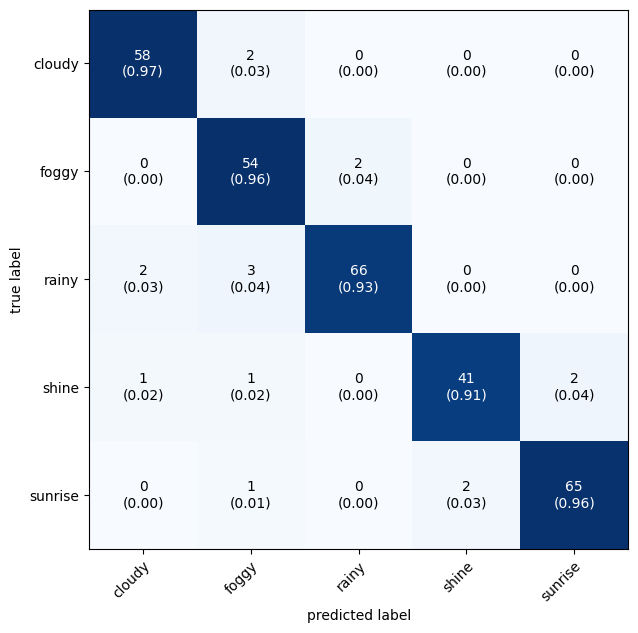

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred_classes)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["cloudy","foggy","rainy","shine","sunrise"],
                      show_normed = True);

"cloudy" was correctly predicted 58 times out of 60, "foggy" 54 out of 56, "rainy" 66 out of 71, "shine" 41 out of 45, and "sunrise" 65 out of 68, indicating high accuracy for each category.

Learning Curve

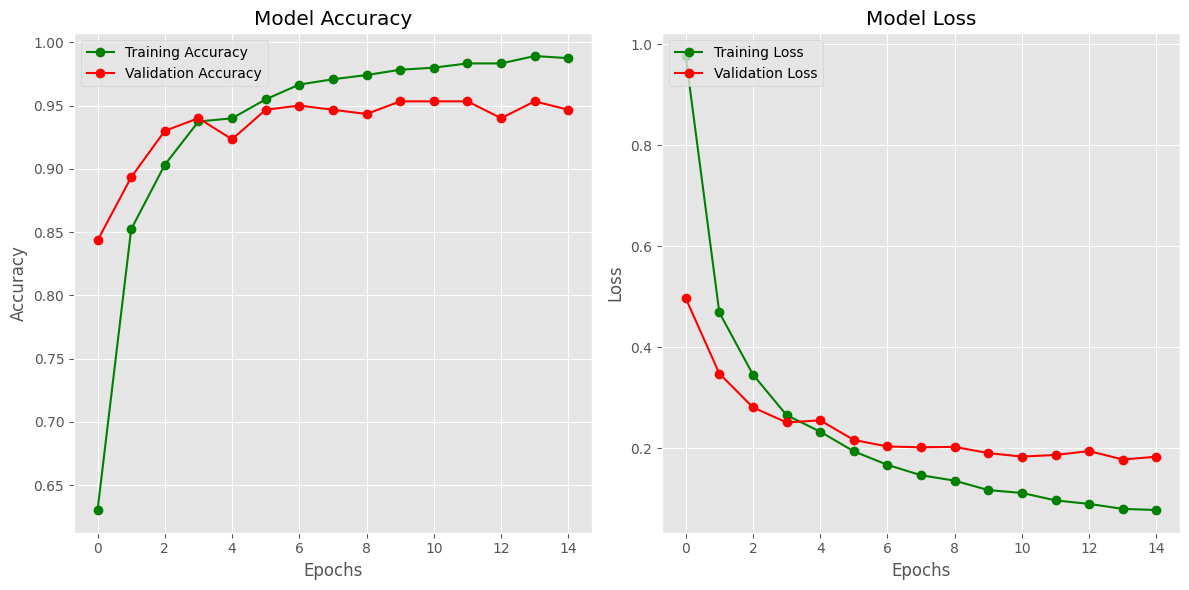

In [ ]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.style.use("ggplot")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Accuracy plot
axes[0].plot(history.epoch, history.history['accuracy'], 'go-', label='Training Accuracy')
axes[0].plot(history.epoch, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='upper left')

# Loss plot
axes[1].plot(history.epoch, history.history['loss'], 'go-', label='Training Loss')
axes[1].plot(history.epoch, history.history['val_loss'], 'ro-', label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


The left graph shows that the training and validation/test accuracy increase with more epochs, which indicates good generalization if the validation/test accuracy remains high. The right graph shows the training and validation/test loss decreasing over time, which is expected as the model learns from the data. A close convergence of validation and training lines typically suggests that the model is not overfitting.